# Libraries and Tools

In [1]:
from utils import *
from student_utils import *
import gurobipy as grb
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Graph Class

In [2]:
"""
A class that performs data preprocessing to gather important data and to provide useful functions
"""
class Graph:
    def __init__(self, input_file):
        parsed_data = data_parser(read_file(input_file))
        self.data = {}
        self.input_file = input_file
        self.number_of_locations = parsed_data[0] 
        self.number_of_houses = parsed_data[1] 
        self.list_of_locations = parsed_data[2]  
        self.list_of_houses = parsed_data[3] 
        self.starting_location = parsed_data[4] 
        self.adjacency_matrix = parsed_data[5] 
        self.G, message = adjacency_matrix_to_graph(self.adjacency_matrix)
        if message:
            print(message)
        else:
            print("Successful creation of Graph instance")
        
    """
    Returns a NumPy matrix of shortest path distances between every pair of nodes using the Floyd-Warshall algorithm. 
    If there is no path between to nodes the corresponding matrix entry will be Inf.
    """
    def get_fw_matrix(self):
        return nx.floyd_warshall_numpy(self.G)

In [3]:
graph = Graph("inputs/84_50.in")
#graph = Graph("inputs/practice.in") # Homework example
#graph = Graph("inputs/264_50.in") # Pauls Example
#graph = Graph("inputs/basic.in") # Basic Example

Successful creation of Graph instance


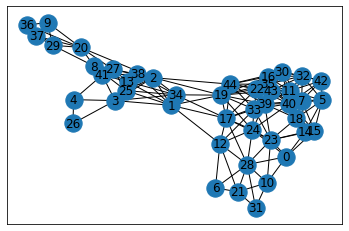

In [4]:
nx.draw_networkx(graph.G)

# Integer Linear Programming

In [5]:
model = grb.Model()

""" Arrangement of Drop-Offs Matrix """
ARRANGEMENTS = []
for r in range(graph.number_of_locations):
    ROW = []
    for c in range(graph.number_of_houses + 2):
        matrix_element_name = "A_" + str(r) + "_" + str(c)
        ROW.append(model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
        model.update()
    ARRANGEMENTS.append(ROW)
ARRANGEMENTS = np.array(ARRANGEMENTS)

""" Arrangement of Drop-Offs Constraints """
# Get the index number of where Soda is
soda = graph.list_of_locations.index(graph.starting_location)
# Check that we start at Soda
model.addConstr(ARRANGEMENTS[soda][0] == 1)
# Check that we end at Soda
model.addConstr(ARRANGEMENTS[soda][graph.number_of_houses + 1] == 1)
# Check that each column of ARRANGEMENTS sums up to 1
for c in range(len(ARRANGEMENTS[0])):
    model.addConstr(grb.quicksum(ARRANGEMENTS[:, c]) == 1)
    
""" TA Walking Matrix """
WALKING = []
for r in range(graph.number_of_locations):
    ROW = []
    for c in range(graph.number_of_locations):
        matrix_element_name = "W_" + str(r) + "_" + str(c)
        ROW.append(model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
        model.update()
    WALKING.append(ROW)
WALKING = np.array(WALKING)

""" TA Walking Constraints """
H = (np.array(convert_locations_to_indices(graph.list_of_locations, graph.list_of_houses)) != None).astype(int)

# Check that each column i of WALKING sums up to H[i]
for i in range(len(WALKING[0])):
    model.addConstr(grb.quicksum(WALKING[:, i]) == H[i])
    
# 0:Soda, 1:Dwinelle, 2:Wheeler, 3:Campanile, 4:Cory, 5:RSF, 6:Barrows
# Homes: Wheeler Campanile Cory RSF
for vertex in range(len(WALKING)):
    model.addConstr(grb.quicksum(WALKING[vertex,:]) == grb.quicksum(ARRANGEMENTS[vertex,1:len(ARRANGEMENTS[0]) - 1]))
    
""" Driving Cost Function """
DISTANCES = graph.get_fw_matrix()
driving_cost_function = []
for c in range(graph.number_of_houses + 1):
    summation = []
    for i in range(graph.number_of_locations):
        for j in range(graph.number_of_locations):
            summation.append(
                grb.QuadExpr(ARRANGEMENTS[i][c] * DISTANCES.item((i, j)) * ARRANGEMENTS[j][c + 1])
            )
            model.update()
    driving_cost_function.append(grb.quicksum(summation))
    
""" Walking Cost Function """
walking_cost_function = []
for row in range(graph.number_of_locations):
    for col in range(graph.number_of_locations):
        walking_cost_function.append(grb.LinExpr(WALKING[row][col] * DISTANCES.item((row, col))))
        model.update()
        
""" Set Objective Function """
cost_function = driving_cost_function + walking_cost_function
model.setObjective(grb.quicksum(cost_function), grb.GRB.MINIMIZE)

""" Minimize Objective Function """
model.optimize()

Academic license - for non-commercial use only
Optimize a model with 110 rows, 2835 columns and 5582 nonzeros
Model has 33660 quadratic objective terms
Variable types: 0 continuous, 2835 integer (2835 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  QObjective range [2e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 501.8000000
Presolve removed 33 rows and 1395 columns
Presolve time: 0.06s
Presolved: 695 rows, 2058 columns, 33816 nonzeros
Variable types: 0 continuous, 2058 integer (1441 binary)

Root relaxation: objective 9.400000e+00, 155 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    9.40000    0   36  501.80000    9.40000  98.1%     -    0s
H    0     0                     301.9000000    9.40000  96.9%     -    0s
H    0

 124420 98203   86.19830  151   47  119.30000   23.39822  80.4%  17.3  315s
 127865 101323   32.42434   82   42  119.30000   23.41746  80.4%  17.3  320s
 131663 104839   38.05513  122   55  119.30000   23.46665  80.3%  17.2  325s
 135218 108020   81.91505  208   53  119.30000   23.49353  80.3%  17.2  330s
 139066 111541   75.51499  128   36  119.30000   23.52943  80.3%  17.2  335s
 142724 114842   33.19030   65   55  119.30000   23.57362  80.2%  17.1  340s
 146745 118546   54.94103  112   59  119.30000   23.60824  80.2%  17.1  345s
 149606 121125   90.51703  228   46  119.30000   23.62053  80.2%  17.2  350s
 153529 124579   35.88337   95   48  119.30000   23.65919  80.2%  17.2  355s
 156566 127322   85.48950  159   28  119.30000   23.68458  80.1%  17.3  360s
 159872 130235   50.80280   70   73  119.30000   23.72109  80.1%  17.2  365s
 162871 133010   87.52835  172   37  119.30000   23.74626  80.1%  17.2  370s
 167550 137278   38.43991   70   62  119.30000   23.78915  80.1%  17.1  375s


 518676 448421   37.53578   79   71  119.30000   26.20182  78.0%  16.8  850s
 522566 451796   75.38095  168   50  119.30000   26.21738  78.0%  16.8  855s
 527348 456125   51.60648  136   42  119.30000   26.23344  78.0%  16.8  860s
 532585 460836   68.85394  133   44  119.30000   26.25407  78.0%  16.8  865s
 536755 464574   52.93875   95   49  119.30000   26.26707  78.0%  16.8  870s
 541279 468537   78.12864  198   36  119.30000   26.28177  78.0%  16.8  875s
 545868 472637   91.13166  203   31  119.30000   26.30359  78.0%  16.8  880s
 550655 476878   47.03085  110   65  119.30000   26.31732  77.9%  16.8  885s
 555328 480983   88.77886  189   29  119.30000   26.33333  77.9%  16.8  890s
 559411 484522   27.94666   97   55  119.30000   26.34411  77.9%  16.8  895s
 564104 488730   32.64394   85   75  119.30000   26.35736  77.9%  16.8  900s
 568675 492775   87.49427  141   20  119.30000   26.37349  77.9%  16.8  905s
 573752 497335     cutoff  253       119.30000   26.39197  77.9%  16.8  910s

 981280 856579   86.81142  159   45  119.30000   27.51929  76.9%  16.7 1385s
 985495 860229   85.49752   79   63  119.30000   27.53038  76.9%  16.7 1390s
 990409 864522   43.00308   84   59  119.30000   27.54099  76.9%  16.7 1395s
 994560 868148   54.87567  157   49  119.30000   27.54996  76.9%  16.7 1400s
 999102 872070   28.61651   70   67  119.30000   27.55925  76.9%  16.7 1405s
 1002518 875084   64.51258  176   45  119.30000   27.56303  76.9%  16.7 1410s
 1007458 879358   43.04010   79   47  119.30000   27.57233  76.9%  16.7 1415s
 1011962 883344   52.79916  140   66  119.30000   27.58387  76.9%  16.7 1420s
 1016583 887358  106.29844  220   49  119.30000   27.59162  76.9%  16.7 1425s
 1020122 890536   89.89381  104   57  119.30000   27.59499  76.9%  16.7 1430s
 1025357 895121   99.28147  206   44  119.30000   27.60306  76.9%  16.7 1435s
 1029798 898967   58.83223  100   48  119.30000   27.61088  76.9%  16.7 1440s
 1034135 902713   87.73844  209   33  119.30000   27.62132  76.8%  16

 1315459 1147779   49.77556  149   46  119.30000   28.10492  76.4%  16.7 2096s
 1317144 1149263   87.35347  172   52  119.30000   28.10708  76.4%  16.7 2100s
 1319975 1151733   44.35066   92   54  119.30000   28.10952  76.4%  16.7 2105s
 1322984 1154458   32.50043  111   52  119.30000   28.11347  76.4%  16.7 2110s
 1324869 1156114   61.94280  133   40  119.30000   28.11722  76.4%  16.7 2115s
 1327925 1158814   80.38266  117   55  119.30000   28.12071  76.4%  16.7 2121s
 1331313 1161755   50.24213  118   76  119.30000   28.12366  76.4%  16.7 2125s
 1335915 1165849   68.48905  114   45  119.30000   28.13084  76.4%  16.7 2130s
 1339942 1169374   56.64365  123   64  119.30000   28.13602  76.4%  16.7 2135s
 1344016 1172973   56.19892  131   59  119.30000   28.14171  76.4%  16.7 2140s
 1348715 1177176   79.11629  197   40  119.30000   28.14746  76.4%  16.7 2145s
 1353132 1180944   48.99819   68   45  119.30000   28.15363  76.4%  16.7 2150s
 1357415 1184569   64.19059  114   53  119.30000   2

In [6]:
A = []
for v in model.getVars():
    if v.VarName[0] == 'A':
        A.append(v.x)

A_matrix = np.array(A).reshape((graph.number_of_locations, graph.number_of_houses + 2))
A_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0

In [ ]:
W = []
for v in model.getVars():
    if v.VarName[0] == 'W':
        W.append(v.x)

W_matrix = np.array(W).reshape((graph.number_of_locations, graph.number_of_locations))
W_matrix